# PyTorch Inception and DenseNet



# Preprocessing


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##### Could clean this up a bit

%matplotlib inline

import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils import data
from torchsummary import summary

from pathlib import Path
from pydicom import dcmread
from tqdm.notebook import tqdm
import skimage.io as sk
from tqdm import tqdm
from PIL import Image

#torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu118


In [ ]:
##### Specify Device

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")


Training on GPU


#Data Preparation

In [ ]:
#Make Labels
df = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/Pneumonia_Labels_Final_2.csv")
df2 = df[['Split','patientId','Target']]

df_train = df2.loc[(df2['Split'] == 'train')]
df_train = df_train.drop(df_train.columns[[0]], axis=1)
df_train = df_train.reset_index(drop=True)

df_val = df2.loc[(df2['Split'] == 'val')]
df_val = df_val.drop(df_val.columns[[0]], axis=1)
df_val = df_val.reset_index(drop=True)

df_test = df2.loc[(df2['Split'] == 'test')]
df_test = df_test.drop(df_test.columns[[0]], axis=1)
df_test = df_test.reset_index(drop=True)

#Reduce Size for testing
#train_total = 200
#val_total = 100
#test_total = 0

#df_train = df_train[:train_total]
#df_val = df_val[:val_total]
#df_test = df_test[:test_total]

#Path Split
root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumonia Dataset/stage_2_train_images_png'

train_labels = df_train[['patientId', 'Target']].to_numpy()
val_labels = df_val[['patientId', 'Target']].to_numpy()
test_labels = df_test[['patientId', 'Target']].to_numpy()

train_paths = [os.path.join(root, image[0]) for image in train_labels]
val_paths = [os.path.join(root, image[0]) for image in val_labels]
test_paths = [os.path.join(root, image[0]) for image in test_labels]

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Split,patientId,x,y,width,height,Target
0,0,0,train,aaa685a7-16f1-448e-af0f-a06867f78e1c,NaN,NaN,NaN,NaN,0
1,1,1,train,5eaecf07-fe6e-4503-a7d9-3b99d344d08a,NaN,NaN,NaN,NaN,0
2,2,2,train,a2990f44-8592-4427-b704-b19565a0bedd,569.0,214.0,284.0,264.0,1
3,3,3,train,5150b314-97cd-4721-9f03-a8d701822630,NaN,NaN,NaN,NaN,0
4,4,4,train,5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6,605.0,435.0,203.0,181.0,1


In [ ]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')
print(len(train_paths))
print(len(val_paths))

patientId: aaa685a7-16f1-448e-af0f-a06867f78e1c, Target: 0
12038
1338


# Transformation & Dataloader


In [ ]:
##### Transformations
transform_v3 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_dense = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##### Custom Dataset

###### READ DICOM ######

class Dataset(data.Dataset):

    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        if label < 0:
          label = 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):

        return len(self.paths)

###### READ PNG ######

class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = (self.annotations.iloc[index, 0] + '.dcm.jpg.png')
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
##### Dataloader ONLY TRAIN AND VAL RIGHT NOW

batch_sz = 4

##### INCEPTION
train_dataset_v3 = PneumoniaDataset(root, df_train, transform=transform_v3)
val_dataset_v3 = PneumoniaDataset(root, df_val, transform=transform_v3)
train_loader_v3 = torch.utils.data.DataLoader(dataset=train_dataset_v3, batch_size=batch_sz, shuffle=True)
val_loader_v3 = torch.utils.data.DataLoader(dataset=val_dataset_v3, batch_size=batch_sz, shuffle=False)

print('Number of training batches', len(train_loader_v3))
print('Number of validation batches', len(val_loader_v3))

##### DENSE
train_dataset_dense = PneumoniaDataset(root, df_train, transform=transform_dense)
val_dataset_dense = PneumoniaDataset(root, df_val, transform=transform_dense)
train_loader_dense = torch.utils.data.DataLoader(dataset=train_dataset_dense, batch_size=batch_sz, shuffle=True)
val_loader_dense = torch.utils.data.DataLoader(dataset=val_dataset_dense, batch_size=batch_sz, shuffle=False)

##### SEPERATING INTO DICTIONARIES FOR EASE OF USE
dataloaders_dict_v3 = {'train': train_loader_v3, 'val': val_loader_v3}
dataloaders_dict_dense = {'train': train_loader_dense, 'val': val_loader_dense}

Number of training batches 3010
Number of validation batches 335


# Data Visualization

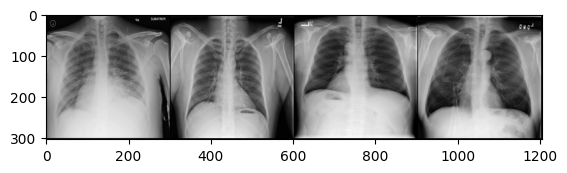

In [ ]:
batch = iter(train_loader_v3)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

#Model Definition

In [ ]:
##### Code from pytorch finetuning torchvision models tutorial
##### From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

##### CHECKPOINT STORAGE
def save_checkpoint(state, filename):
  print("=======> SAVING CHECKPOINT")
  torch.save(state, filename)

###### FEATURE EXTRACT
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

##### TRAIN FUNCTION
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_progress = tqdm(total=len(dataloaders['train']) + len(dataloaders['val']), position=0, leave=True, desc='Epoch Progress')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            dataloader = dataloaders[phase]

            for inputs, labels in dataloader:
                labels = labels.type(torch.LongTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                del loss
                del outputs

                epoch_progress.update()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                if model_name == "inception":
                    checkpoint_inception = model
                    save_checkpoint(checkpoint_inception, "/content/drive/MyDrive/Saliency Map Research 2023/Models/pneumonia_inception.pt")
                elif model_name == "densenet":
                    checkpoint_dense = model
                    save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/pneumonia_dense.pt")
                elif model_name == "resnet":
                    checkpoint_dense = model
                    save_checkpoint(checkpoint_dense, "/content/drive/MyDrive/Saliency Map Research 2023/Models/pneumonia_resnet.pt")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        epoch_progress.close()

        torch.cuda.empty_cache()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

##### INITIALIZE
def initialize_model(model_name, num_classes,feature_extract):
  model_ft = None
  input_size = 0

  if model_name == "densenet":
      model_ft = models.densenet121(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.classifier.in_features
      model_ft.classifier = nn.Linear(1024, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 224

  elif model_name == "inception":
      """ Inception v3
      Be careful, expects (299,299) sized images and has auxiliary output
      """
      model_ft = models.inception_v3(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.AuxLogits.fc.in_features
      model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs,num_classes)
      ##### NUM CLASSES ON LAST FC MIGHT NEED FIXING
      input_size = 299

  elif model_name == "resnet":
      """ Resnet101
      """
      model_ft = models.resnet101(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224

  else:
      print("Invalid model name, exiting...")
      exit()

  return model_ft, input_size

In [ ]:
num_classes = 2

##### Pneumonia Numbers
densenet_early_stopping = 0.927
inception_early_stopping = 0.936
##### No early stopping used in this iteration

#metric = BinaryAUROC(thresholds=None)

# Inception V3 Model

In [ ]:
##### INPUTS

num_epochs_v3 = 20
model_name_v3 = "resnet"
m = nn.Sigmoid()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
feature_extract = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_ft, input_size = initialize_model(model_name_v3, num_classes, feature_extract)
#print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
###### UPDATING MODEL PARAMETERS, GET SUMMARY

model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft_v3 = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft_v3 = optim.Adam(params_to_update, lr=1e-4)

#summary(model_ft, (3, 299, 299))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_ft, hist = train_model(model_ft, model_name_v3, dataloaders_dict_v3, criterion, optimizer_ft_v3, num_epochs=num_epochs_v3, is_inception=(model_name_v3=="inception"))

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


Epoch Progress:  90%|████████▉ | 3010/3345 [1:19:25<07:24,  1.33s/it]

train Loss: 0.3238 Acc: 0.8799


Epoch Progress: 100%|██████████| 3345/3345 [1:27:53<00:00,  1.33s/it]

val Loss: 0.2755 Acc: 0.9170
=======> SAVING CHECKPOINT


Epochs:   5%|▌         | 1/20 [1:27:54<27:50:15, 5274.48s/it]


Epoch 1/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:25<01:10,  4.72it/s]

train Loss: 0.1821 Acc: 0.9365


Epoch Progress: 100%|█████████▉| 3344/3345 [14:18<00:00,  6.24it/s]

val Loss: 0.2529 Acc: 0.9208
=======> SAVING CHECKPOINT


Epochs:  10%|█         | 2/20 [1:42:14<13:23:14, 2677.48s/it]


Epoch 2/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:27<01:10,  4.71it/s]

train Loss: 0.1535 Acc: 0.9484


Epoch Progress: 100%|█████████▉| 3344/3345 [14:21<00:00,  6.05it/s]

val Loss: 0.1579 Acc: 0.9425
=======> SAVING CHECKPOINT


Epochs:  15%|█▌        | 3/20 [1:56:35<8:43:42, 1848.39s/it] 


Epoch 3/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:27<01:10,  4.71it/s]

train Loss: 0.1358 Acc: 0.9511


Epochs:  20%|██        | 4/20 [2:10:56<6:28:55, 1458.49s/it]

val Loss: 0.1675 Acc: 0.9402

Epoch 4/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:33<01:11,  4.65it/s]

train Loss: 0.1235 Acc: 0.9571


Epoch Progress: 100%|█████████▉| 3344/3345 [14:28<00:00,  6.03it/s]

val Loss: 0.1440 Acc: 0.9514
=======> SAVING CHECKPOINT


Epochs:  25%|██▌       | 5/20 [2:25:25<5:11:27, 1245.84s/it]


Epoch 5/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:35<01:11,  4.68it/s]

train Loss: 0.1075 Acc: 0.9620


Epochs:  30%|███       | 6/20 [2:39:56<4:20:57, 1118.37s/it]

val Loss: 0.1519 Acc: 0.9439

Epoch 6/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:32<01:11,  4.67it/s]

train Loss: 0.1004 Acc: 0.9640


Epochs:  35%|███▌      | 7/20 [2:54:23<3:44:32, 1036.33s/it]

val Loss: 0.1578 Acc: 0.9469

Epoch 7/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:32<01:10,  4.73it/s]

train Loss: 0.0835 Acc: 0.9708


Epochs:  40%|████      | 8/20 [3:08:51<3:16:30, 982.57s/it] 

val Loss: 0.2022 Acc: 0.9350

Epoch 8/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:31<01:12,  4.63it/s]

train Loss: 0.0768 Acc: 0.9739


Epochs:  45%|████▌     | 9/20 [3:23:17<2:53:29, 946.27s/it]

val Loss: 0.1646 Acc: 0.9425

Epoch 9/19
----------


Epoch Progress:  90%|█████████ | 3011/3345 [13:29<01:11,  4.67it/s]

train Loss: 0.0704 Acc: 0.9754


Epochs:  50%|█████     | 10/20 [3:37:40<2:33:26, 920.62s/it]

val Loss: 0.1794 Acc: 0.9492

Epoch 10/19
----------


Epochs:  50%|█████     | 10/20 [3:38:36<3:38:36, 1311.63s/it]


FileNotFoundError: ignored

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/Saliency Map Research 2023/Repeatability/new model/new_inception2.pt')

#Dense-Net 121

In [ ]:
##### DENSE NET 121 MODEL #####

##### DENSE NET NEXT
##### POTENTIALLY MOVE TO NEW NOTEBOOK

#dense = models.densenet121(pretrained=True)
model_name_dense = "densenet"
#criterion = nn.BCEWithLogitsLoss()
num_epochs_dense = 20

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name_dense, num_classes, feature_extract)

In [ ]:
###### UPDATING MODEL PARAMETERS, GET SUMMARY

model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft_dense = optim.Adam(params_to_update, lr=7e-5)

#summary(model_ft, (3, 299, 299))

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, model_name_dense, dataloaders_dict_dense, criterion, optimizer_ft_dense, num_epochs=num_epochs_dense, is_inception=False)

#ResNet101


In [ ]:
##### ResNet 101 MODEL #####

##### Used for object detection
#####

resnet = models.resnet101(pretrained=True)
model_name_resnet = "resnet"
#criterion = nn.BCEWithLogitsLoss()
num_epochs_resnet = 20

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name_resnet, num_classes, feature_extract)

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
optimizer_ft_resnet = optim.Adam(params_to_update, lr=1e-4)

#summary(model_ft, (3, 224, 224))

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, model_name_resnet, dataloaders_dict_dense, criterion, optimizer_ft_resnet, num_epochs=num_epochs_resnet, is_inception=False)